In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sentinelhub import SHConfig
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

In [2]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os
import numpy as np
from utils import get_map
import datetime
import os
import matplotlib.pyplot as plt
from sentinelhub import CRS, BBox, bbox_to_dimensions
from utils import evalscript_true_color, evalscript_ndvi, evalscript_ndwi
from utils import center_crop
from config import IMAGE_SIZE
from utils import to_grayscale
import cv2
from utils import generated_lsm_mask
from PIL import Image
from torch.utils.data import DataLoader
from dataset import Image_dataset
from generator_model import Generator
from torch import optim
import torch
from config import DEVICE
import folium

# Load model
gen = Generator(in_channels=3, inter_images=4, out_channels=3)
checkpoint = torch.load("model/gen_LSM_v2.pth.tar", map_location=torch.device(DEVICE))
gen.load_state_dict(checkpoint['state_dict'])

optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])

config_sentinel = SHConfig(sh_client_id=os.environ.get("sh_client_id"), sh_client_secret=os.environ.get("sh_client_secret"))
# config_sentinel.sh_client_id

torch.Size([5, 128, 100, 100])


In [3]:
from mapping_automation import find_best_date, subtract_km_from_coordinates, get_cloud_coverage, search_available_dates, get_access_token, get_slope_elevation
from scripts import *
from utils import *
import os
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
date = "2024-05-06"
lat, lon = 33.135611, 75.435993
grid = 1
box_dim = 3 # km
res = 1000

In [13]:
g = generate_grid(lat, lon, distance=box_dim*1000, grid_side=grid)
m = folium.Map(
    location=(lat, lon),
    zoom_start=15,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)   
for i in range(len(g)):
    folium.Rectangle([(g[i][:2]), (g[i][2:])], color='red', fill='pink',fill_opcity=0.5).add_to(m)

m

In [14]:
g

[[33.135611, 75.435993, 33.162590648177556, 75.4682121549811]]

In [15]:
def get_images(km, grid, grid_dim, script, box_dim=400, date_start = "2024-04-12", date_end = "2024-04-12", res=2100, file_name=None):
    _box_dim = 1000 if km < 100 else km
    canvas = np.zeros(((grid_dim) * _box_dim, (grid_dim) * _box_dim, 3), dtype=np.uint8)

    row = 0
    col = 0

    for idx, i in enumerate(range(len(grid))):
        y_start = _box_dim * col
        y_end = _box_dim * (col + 1)
        x_start = _box_dim * row
        x_end = _box_dim * (row + 1)

        print(col, row, grid[idx], "->", y_start, y_end, x_start, x_end) 

        image_rgba = cv2.resize(
        get_suseptibility_mapping(grid[idx], script, date_start=date_start, date_end=date_end, res=res, box_dim=box_dim), (_box_dim,_box_dim)
        )
        if image_rgba.shape[-1] == 4:
            image_rgb = image_rgba[..., :3]
        else: image_rgb = image_rgba
        canvas[y_start:y_end, x_start:x_end] = image_rgb

        if file_name: 
            plt.imsave(f"{file_name}.png", canvas)
            print(f"Saved: {file_name}.png")

        row += 1  # Move to the next column
        if (idx + 1) % math.sqrt(len(grid)) == 0:
            print("----") 
            col += 1  # Move to the next row
            row = 0  # Reset column position
    return canvas

In [ ]:
row = 0
col = 0
get_new_dates_for_each = True

_box_dim = 1000 if box_dim < 100 else box_dim

canvas_True_Color_After = np.zeros(((grid) * _box_dim, (grid) * _box_dim, 3), dtype=np.uint8)
canvas_NDVI_Before = np.zeros(((grid) * _box_dim, (grid) * _box_dim, 3), dtype=np.uint8)
canvas_Elevation = np.zeros(((grid) * _box_dim, (grid) * _box_dim, 3), dtype=np.uint8)
canvas_Slope = np.zeros(((grid) * _box_dim, (grid) * _box_dim, 3), dtype=np.uint8)
canvas_NDWI_Before = np.zeros(((grid) * _box_dim, (grid) * _box_dim, 3), dtype=np.uint8)
canvas_generated_output = np.zeros(((grid) * _box_dim, (grid) * _box_dim, 3), dtype=np.uint8)/255

for idx, i in enumerate(range(len(g))):
    if get_new_dates_for_each or idx==0:
        lat, lon = g[idx][0], g[idx][1]
        print("Getting dates for new lat lon")
        available_dates = search_available_dates(target_date=date,
                                                lat = lat,
                                                lon = lon)
        available_dates_cloud_coverage = get_cloud_coverage(lat=lat, lon=lon, date_list=available_dates)
        min_before_date, min_before_cc, min_after_date, min_after_cc = find_best_date({k: v for k, v in available_dates_cloud_coverage.items() if v is not None}, target_date=date)
        print(min_before_date,":" , min_before_cc, min_after_date,":" ,min_after_cc)
    
    y_start = _box_dim * col
    y_end = _box_dim * (col + 1)
    x_start = _box_dim * row
    x_end = _box_dim * (row + 1)

    print("NDVI_Before")
    NDVI_Before = get_images(km=box_dim, grid=[g[i]], grid_dim=1, script=evalscript_True_Color, 
           date_start=min_before_date, date_end=min_before_date, res=res, 
           box_dim=box_dim)

    print("True_Color_After")
    True_Color_After = get_images(km=box_dim, grid=[g[i]], grid_dim=1, script=evalscript_True_Color, 
            date_start=min_before_date, date_end=min_before_date, res=res,                            ## idk fix this: True_Color_After should have been True_Color_Before
            box_dim=box_dim)
    canvas_True_Color_After[y_start:y_end, x_start:x_end] = True_Color_After

    print("NDWI_Before")
    NDWI_Before = get_images(km=box_dim, grid=[g[i]], grid_dim=1, script=evalscript_NDWI, 
            date_start=min_before_date, date_end=min_before_date, res=res, 
            box_dim=box_dim)
    canvas_NDWI_Before[y_start:y_end, x_start:x_end] = NDWI_Before

    slope_arr, elevation_arr = get_slope_elevation([g[idx]])
    slope_arr = cv2.resize(slope_arr, (1000,1000))
    elevation_arr = cv2.resize(elevation_arr, (1000,1000))

    print("Generated Output")
    generated_output = gen(torch.tensor(cv2.resize(True_Color_After, (512, 512))).permute(2, 0, 1).unsqueeze(0).to(torch.float32),
    z1 = torch.tensor(cv2.resize(NDVI_Before, (512, 512))).permute(2, 0, 1).unsqueeze(0).to(torch.float32),
    z2 = torch.tensor(cv2.resize(slope_arr, (512, 512))).unsqueeze(-1).repeat(1, 1, 3).permute(2, 0, 1).unsqueeze(0).to(torch.float32),
    z3 = torch.tensor(cv2.resize(elevation_arr, (512, 512))).unsqueeze(-1).repeat(1, 1, 3).permute(2, 0, 1).unsqueeze(0).to(torch.float32),
    z4 = torch.tensor(cv2.resize(NDWI_Before, (512, 512))).permute(2, 0, 1).unsqueeze(0).to(torch.float32)
    )
    canvas_generated_output[y_start:y_end, x_start:x_end] = cv2.resize(generated_output[0].permute(1, 2, 0).detach().cpu().numpy(), (1000,1000))*0.5+0.5

    row += 1  # Move to the next column
    if (idx + 1) % math.sqrt(len(g)) == 0:
        print("----") 
        col += 1  # Move to the next row
        row = 0  # Reset column position

Getting dates for new lat lon
2024-04-06 : 0.28 2024-05-16 : 0.61
NDVI_Before
0 0 [33.135611, 75.435993, 33.162590648177556, 75.4682121549811] -> 0 1000 0 1000
----
True_Color_After
0 0 [33.135611, 75.435993, 33.162590648177556, 75.4682121549811] -> 0 1000 0 1000
----
NDWI_Before
0 0 [33.135611, 75.435993, 33.162590648177556, 75.4682121549811] -> 0 1000 0 1000
----
Generated Output
----


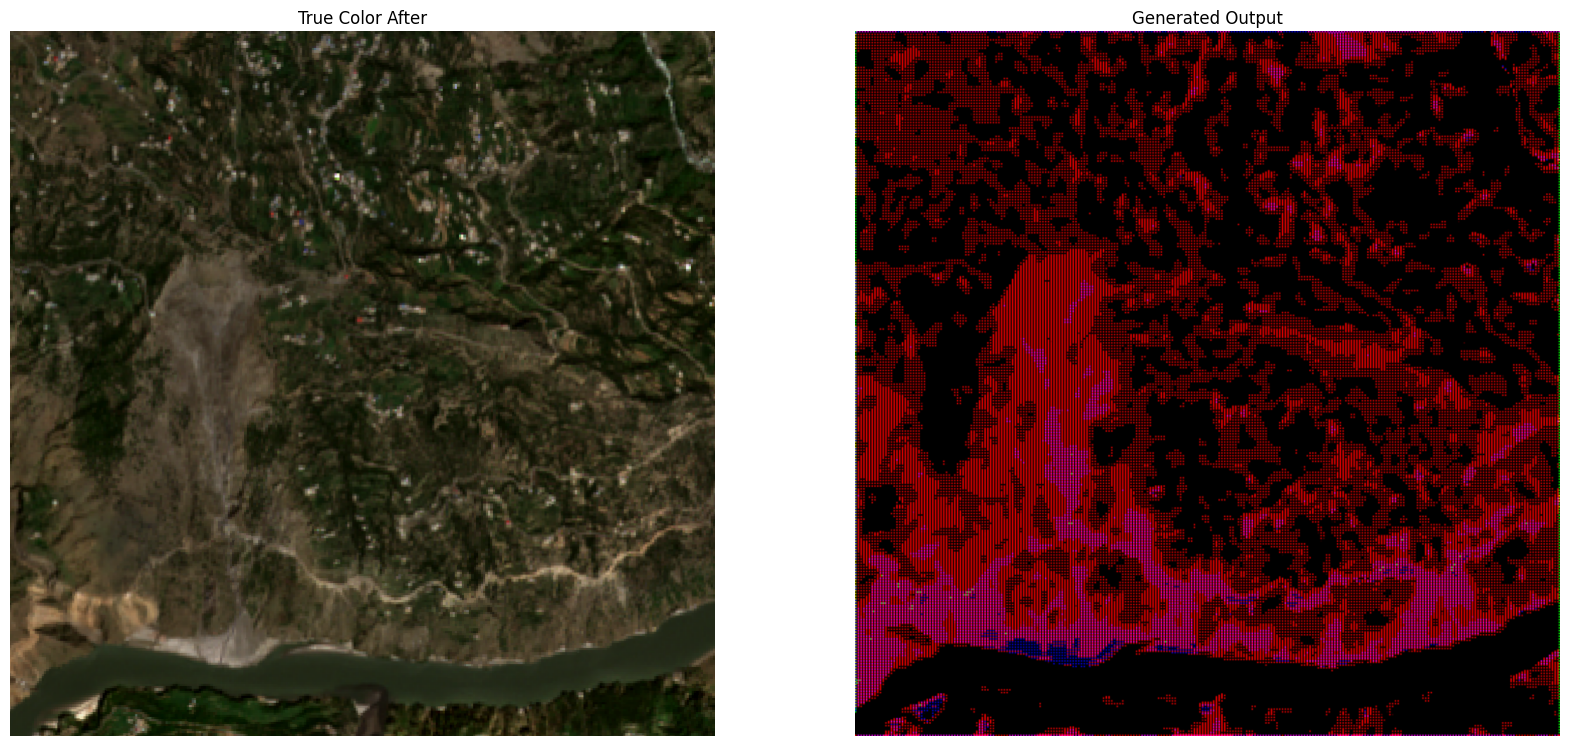

In [17]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title("True Color After")
plt.imshow(canvas_True_Color_After)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Generated Output")
plt.imshow(canvas_generated_output)
plt.axis('off')

plt.show()

In [15]:
import gradio as gr

iface = gr.Interface(
    fn=main,
    inputs=[gr.Number(label="Latitude"), gr.Number(label="Longitude"), gr.Number(label="Grid")],
    outputs=[
        gr.Image(type="pil", label="Map Image"),
        gr.Image(type="pil", label="Canvas"),
        gr.Image(type="pil", label="Prediction")
    ],
    # live=True
)
iface.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


Fetching colored Sat image
Adding rectangle gird
Generated Prediction


  0%|          | 0/1 [00:00<?, ?it/s]

[80.094545, 12.892824, 80.10748381107044, 12.905436612612611]


100%|██████████| 1/1 [00:16<00:00, 16.92s/it]


Blur and threshold
Map to png
Getting image of different features
Normalizing and resize
Fetching colored Sat image
Adding rectangle gird
Generated Prediction


  0%|          | 0/2 [00:00<?, ?it/s]

[80.086706, 12.884758, 80.09964439427225, 12.897370612612612]
[80.086706, 12.897370612612612, 80.09964439427225, 12.909983225225226]


 50%|█████     | 1/2 [00:34<00:34, 34.73s/it]

[80.09964439427225, 12.884758, 80.11258278854449, 12.897370612612612]
[80.09964439427225, 12.897370612612612, 80.11258278854449, 12.909983225225226]


100%|██████████| 2/2 [01:06<00:00, 33.29s/it]


Blur and threshold
Map to png
Getting image of different features
Normalizing and resize
Fetching colored Sat image
Adding rectangle gird
Generated Prediction


  0%|          | 0/3 [00:00<?, ?it/s]

[74.605624, 35.181401, 74.62105544404827, 35.194013612612615]
[74.605624, 35.194013612612615, 74.62105544404827, 35.20662622522522]
[74.605624, 35.20662622522522, 74.62105544404827, 35.219238837837835]


 33%|███▎      | 1/3 [01:04<02:08, 64.27s/it]

[74.62105544404827, 35.181401, 74.63648688809651, 35.194013612612615]
[74.62105544404827, 35.194013612612615, 74.63648688809651, 35.20662622522522]
[74.62105544404827, 35.20662622522522, 74.63648688809651, 35.219238837837835]


 67%|██████▋   | 2/3 [02:11<01:06, 66.04s/it]

[74.63648688809651, 35.181401, 74.65191833214477, 35.194013612612615]
[74.63648688809651, 35.194013612612615, 74.65191833214477, 35.20662622522522]
[74.63648688809651, 35.20662622522522, 74.65191833214477, 35.219238837837835]


100%|██████████| 3/3 [03:13<00:00, 64.56s/it]


Blur and threshold
Map to png
Getting image of different features
Normalizing and resize
Fetching colored Sat image


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gradio/blocks.py", line 1935, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gradio/blocks.py", line 1520, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/L

Fetching colored Sat image
Adding rectangle gird
Generated Prediction


  0%|          | 0/3 [00:00<?, ?it/s]

[86.868376, 27.9656, 86.88265611117218, 27.978212612612612]
[86.868376, 27.978212612612612, 86.88265611117218, 27.990825225225223]
[86.868376, 27.990825225225223, 86.88265611117218, 28.003437837837836]


 33%|███▎      | 1/3 [00:56<01:53, 56.88s/it]

[86.88265611117218, 27.9656, 86.89693622234437, 27.978212612612612]
[86.88265611117218, 27.978212612612612, 86.89693622234437, 27.990825225225223]
[86.88265611117218, 27.990825225225223, 86.89693622234437, 28.003437837837836]


 67%|██████▋   | 2/3 [01:51<00:55, 55.75s/it]

[86.89693622234437, 27.9656, 86.91121633351655, 27.978212612612612]
[86.89693622234437, 27.978212612612612, 86.91121633351655, 27.990825225225223]
[86.89693622234437, 27.990825225225223, 86.91121633351655, 28.003437837837836]


100%|██████████| 3/3 [02:40<00:00, 53.62s/it]


Blur and threshold
Map to png
Getting image of different features
Normalizing and resize
Fetching colored Sat image
Adding rectangle gird
Generated Prediction


  0%|          | 0/5 [00:00<?, ?it/s]

[86.760695, 27.860021, 86.77496117790136, 27.872633612612614]
[86.760695, 27.872633612612614, 86.77496117790136, 27.885246225225224]
[86.760695, 27.885246225225224, 86.77496117790136, 27.897858837837838]
[86.760695, 27.897858837837838, 86.77496117790136, 27.910471450450448]
[86.760695, 27.910471450450448, 86.77496117790136, 27.92308406306306]


 20%|██        | 1/5 [01:17<05:08, 77.25s/it]

[86.77496117790136, 27.860021, 86.78922735580272, 27.872633612612614]
[86.77496117790136, 27.872633612612614, 86.78922735580272, 27.885246225225224]
[86.77496117790136, 27.885246225225224, 86.78922735580272, 27.897858837837838]
[86.77496117790136, 27.897858837837838, 86.78922735580272, 27.910471450450448]
[86.77496117790136, 27.910471450450448, 86.78922735580272, 27.92308406306306]


 40%|████      | 2/5 [02:28<03:41, 73.91s/it]

[86.78922735580272, 27.860021, 86.80349353370407, 27.872633612612614]
[86.78922735580272, 27.872633612612614, 86.80349353370407, 27.885246225225224]
[86.78922735580272, 27.885246225225224, 86.80349353370407, 27.897858837837838]
[86.78922735580272, 27.897858837837838, 86.80349353370407, 27.910471450450448]
[86.78922735580272, 27.910471450450448, 86.80349353370407, 27.92308406306306]


 60%|██████    | 3/5 [03:38<02:24, 72.20s/it]

[86.80349353370407, 27.860021, 86.81775971160543, 27.872633612612614]
[86.80349353370407, 27.872633612612614, 86.81775971160543, 27.885246225225224]
[86.80349353370407, 27.885246225225224, 86.81775971160543, 27.897858837837838]
[86.80349353370407, 27.897858837837838, 86.81775971160543, 27.910471450450448]
[86.80349353370407, 27.910471450450448, 86.81775971160543, 27.92308406306306]


 80%|████████  | 4/5 [04:49<01:11, 71.35s/it]

[86.81775971160543, 27.860021, 86.8320258895068, 27.872633612612614]
[86.81775971160543, 27.872633612612614, 86.8320258895068, 27.885246225225224]
[86.81775971160543, 27.885246225225224, 86.8320258895068, 27.897858837837838]
[86.81775971160543, 27.897858837837838, 86.8320258895068, 27.910471450450448]
[86.81775971160543, 27.910471450450448, 86.8320258895068, 27.92308406306306]


100%|██████████| 5/5 [06:00<00:00, 72.18s/it]


Blur and threshold
Map to png
Getting image of different features
Normalizing and resize


In [11]:
cords = sub_boxes[0][0]
resolution = 0.8
bbox = BBox(bbox=list(cords), crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 0.8 m resolution: (1716, 1792) pixels


In [12]:
maps = get_map(list(cords), start_date="2021-06-12", end_date="2023-07-13", 
        evalscript_ndvi=evalscript_ndvi, 
        evalscript_true_color=evalscript_true_color, 
        evalscript_ndwi=evalscript_ndwi)

In [39]:
# gray_image, NDVI, Slope, Elevation, NDWI

In [16]:
new_shape = (IMAGE_SIZE, IMAGE_SIZE)

gray_image = cv2.resize(to_grayscale(maps[0]), (new_shape[0], new_shape[1]))
NDVI = cv2.resize(maps[1], (new_shape[0], new_shape[1]))
Slope = cv2.resize(maps[2], (new_shape[0], new_shape[1]))
Elevation = cv2.resize(maps[3], (new_shape[0], new_shape[1]))
NDWI = cv2.resize(maps[4], (new_shape[0], new_shape[1]))

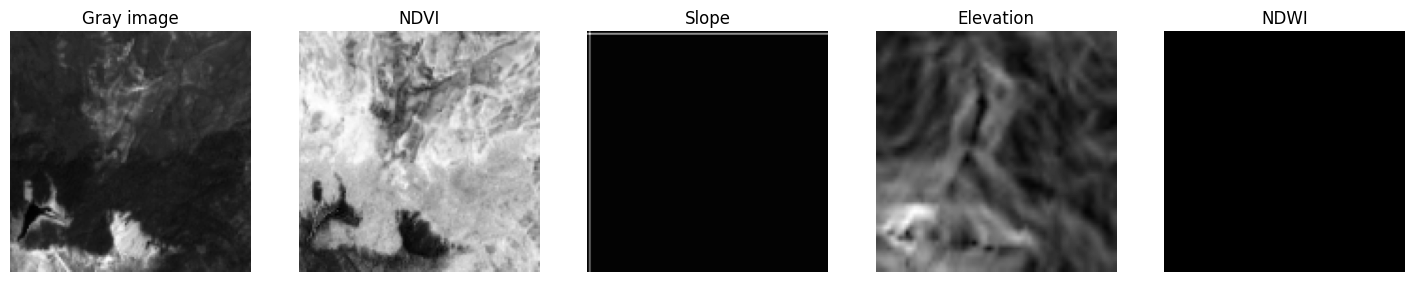

In [17]:
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(18,6))

ax1.set_title("Gray image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("NDWI")

ax1.imshow(gray_image, cmap="gray")
ax2.imshow(NDVI, cmap="gray")
ax3.imshow(Slope, cmap="gray")
ax4.imshow(Elevation, cmap="gray")
ax5.imshow(NDWI, cmap="gray")

ax1.axis("off"); ax2.axis("off"), ax3.axis("off"); ax4.axis("off"), ax5.axis("off")
plt.show()


In [18]:
gray_image_n = cv2.normalize(gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
NDVI_n = cv2.normalize(NDVI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
Slope_n = cv2.normalize(Slope, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
Elevation_n = cv2.normalize(Elevation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
NDWI_n = cv2.normalize(NDWI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

(-0.5, 639.5, 127.5, -0.5)

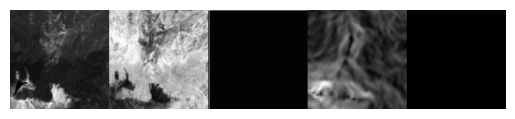

In [20]:
canvas = np.ones((128, 128*5))
canvas[:, 0:128] = gray_image_n
canvas[:, 128:128*2] = NDVI_n
canvas[:, 128*2:128*3] = Slope_n
canvas[:, 128*3:128*4] = Elevation_n
canvas[:, 128*4:128*5] = NDWI_n

plt.imshow(canvas, cmap="gray")
plt.axis("off")

In [ ]:
# pred = generated_lsm_mask(gen, canvas, already_grayscale=True)
# b_i = cv2.blur(pred, (5, 5))
# thresholded = (b_i > 0.1) & (b_i < 0.9)

# plt.imshow(thresholded.astype(float), cmap="gray")
# plt.title("Thresholded and Blurred Prediction")
# plt.axis("off")
# plt.show()